In [1]:
# Check the top right corner to make sure you are running in the appropriate virtual environment (see Tutorial_1 in week 1)

# 1. Convolutions for Images

## 1.1 The Cross-Correlation Operation
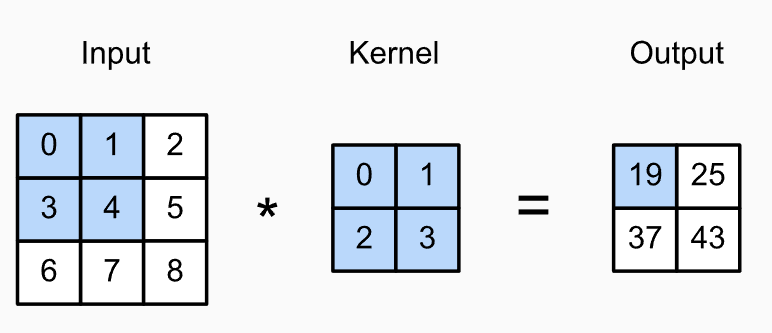

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K): 
    """Compute 2D cross-correlation."""
    """K is the kernel matrix, X is the input"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

If you encounter an error in running the above codes: DLL load failed while importing _imaging
Please try to downgrade your pillow version in your environment: 

In [3]:
# pip install pillow==6.2.1
# or
# pip install pillow==6.2.1 -i https://pypi.tuna.tsinghua.edu.cn/simple/

validate the output of the above implementation of the two-dimensional cross-correlation operation.

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
print(X), print(K)
corr2d(X, K)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[0., 1.],
        [2., 3.]])


tensor([[19., 25.],
        [37., 43.]])

## 1.2 Convolutional Layers

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## 1.3 A simple application of a convolutional layer: Object Edge Detection in Images

In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]])

we detect 1 for the edge from white to black and -1 for the edge from black to white. All other outputs take value 0.

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Apply the kernel to the transposed image. As expected, it vanishes. The kernel K only detects vertical edges.

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 1.4 Learning a Kernel

Now let’s see whether we can learn the kernel that generated Y from X by looking at the input–output pairs only. We first construct a convolutional layer and initialize its kernel as a random tensor. Next, in each iteration, we will use the squared error to compare Y with the output of the convolutional layer. We can then calculate the gradient to update the kernel. For the sake of simplicity, in the following we use the built-in class for two-dimensional convolutional layers and ignore the bias.

In [10]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    loss = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    loss.sum().backward()
    # Update the kernel: Gradient descent
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {loss.sum():.3f}')

epoch 2, loss 8.198
epoch 4, loss 2.079
epoch 6, loss 0.637
epoch 8, loss 0.225
epoch 10, loss 0.086


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel tensor we learned.

In [11]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9585, -1.0176]])

# 2. Padding and Stride

## 2.1 Padding
One tricky issue when applying convolutional layers is that we tend to lose pixels on the perimeter of our image. Consider the figure below that depicts the pixel utilization as a function of the convolution kernel size and the position within the image. The pixels in the corners are hardly used at all.

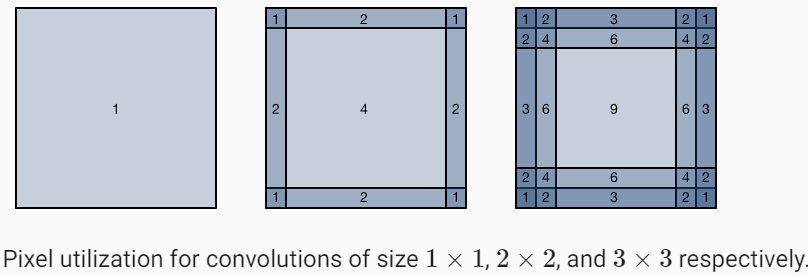

One straightforward solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero.

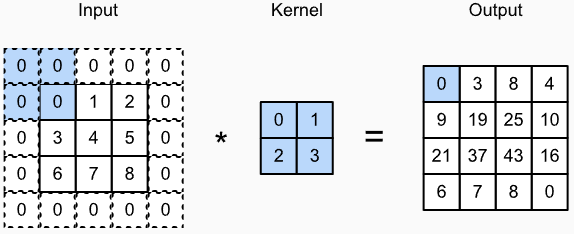

In general, if we add a total of ph rows of padding (roughly half on top and half on bottom) and a total of pw columns of padding (roughly half on the left and half on the right), the output shape will be:

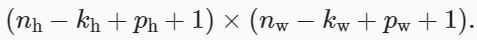

If we want the same height and width as that of the input, we may set:

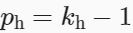


If kh or kw is even, one possible way is to pad on one side.

In the following example, we create a two-dimensional convolutional layer with a height and width of 3 and apply 1 pixel of padding on all sides. Given an input with a height and width of 8, we find that the height and width of the output is also 8.

In [12]:
import torch
from torch import nn


# We define a convenience function to calculate the convolutional layer. This
# function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.reshape(Y.shape[2:])
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [13]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 2.2 Stride
Sometimes, we move our window more than one element at a time, skipping the intermediate locations. 

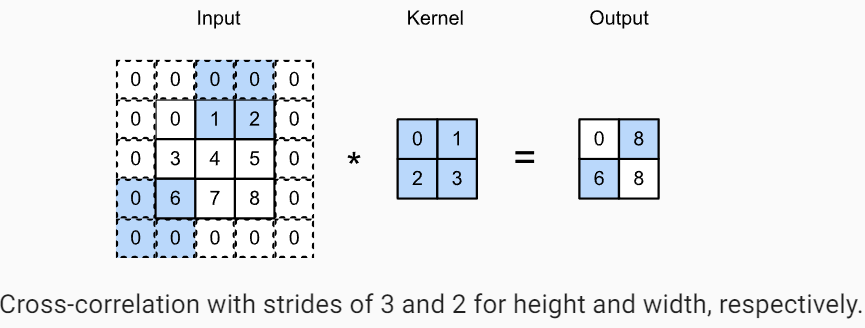

In [14]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# 3. Multiple Input and Multiple Output Channels

There may be multiple input channels for an image (E.g., RGB, three channels for most images).
The calculation could be (2 channels in the image):

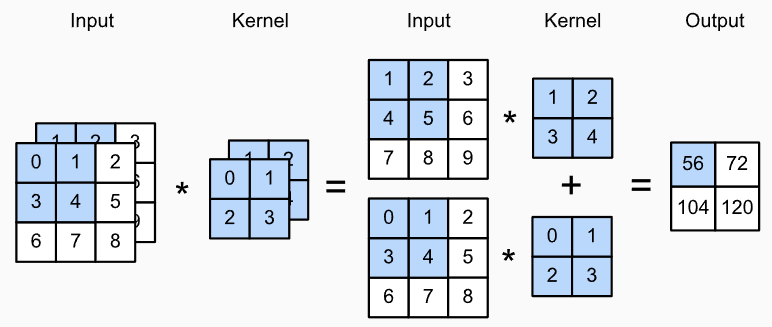

In [16]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [17]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

You may also want K output channels by creating K kernels as above.

In [18]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [19]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [20]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

So, if you have multiple 1*1 kernels, they can help you adjust your channel dimension without doing convolution on the other two dimensions!

In [21]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

When performing convolutions, the above function is equivalent to the previously implemented cross-correlation function corr2d_multi_in_out. Let’s check this with some sample data.

In [22]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
Y1, Y2

(tensor([[[ 1.0479,  1.9124, -0.3965],
          [-0.1368,  0.9540, -0.6903],
          [ 4.7534, -0.0065, -1.0780]],
 
         [[ 0.2274,  1.3852, -0.3445],
          [-0.0207,  0.1418, -0.0398],
          [ 2.2464, -0.2332, -0.3824]]]),
 tensor([[[ 1.0479,  1.9124, -0.3965],
          [-0.1368,  0.9540, -0.6903],
          [ 4.7534, -0.0065, -1.0780]],
 
         [[ 0.2274,  1.3852, -0.3445],
          [-0.0207,  0.1418, -0.0398],
          [ 2.2464, -0.2332, -0.3824]]]))

# 4. Pooling
It serves the dual purpose of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

### Max pooling

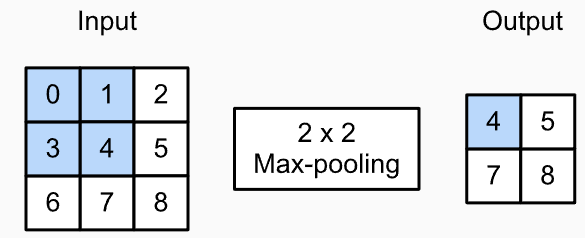

### Average Pooling

Use the average function instead of the max function

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [24]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [25]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

# 5. Convolutional Neural Networks (LeNet)

## 5.1 LeNet

LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of two convolutional layers; and (ii) a dense block consisting of three fully-connected layers;

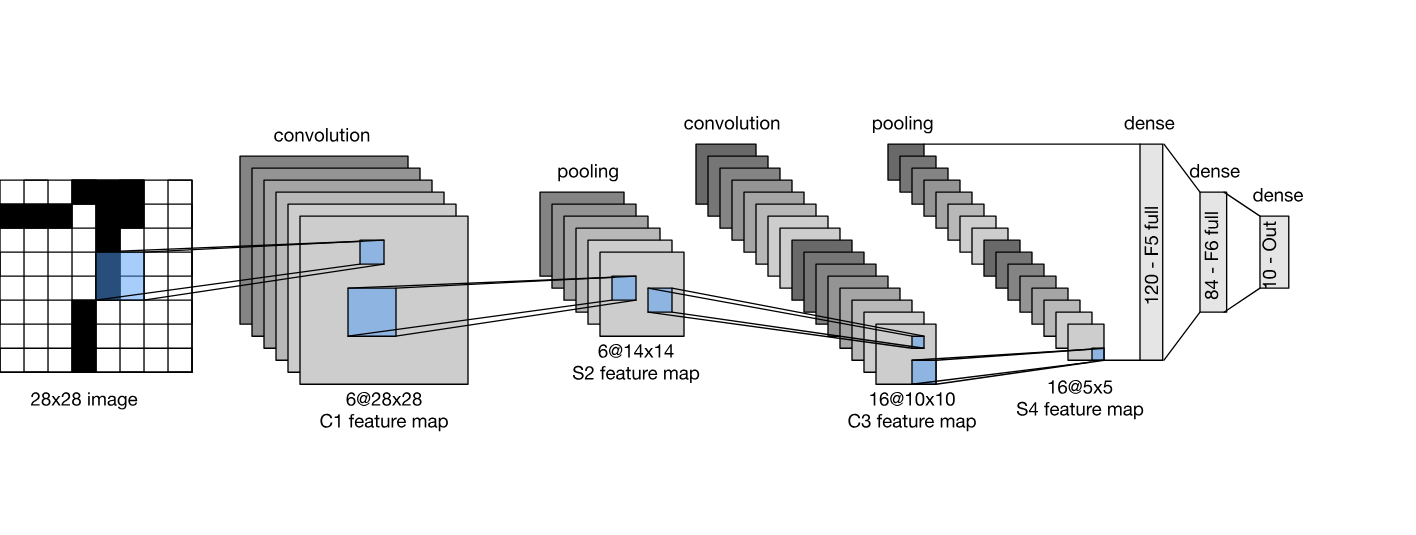

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [27]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


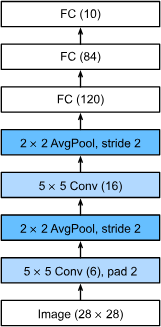

## 5.2 Training

In [28]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [29]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [30]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.467, train acc 0.824, test acc 0.820
29018.5 examples/sec on cuda:0


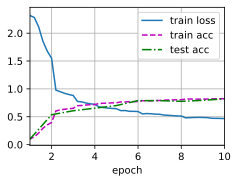

In [31]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())